In [508]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
from typing import Tuple
from pathlib import Path

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score, auc, log_loss, average_precision_score
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost as xgb

In [509]:
pd.set_option('display.max_columns', None)

In [510]:
data_path = Path("../data")

In [511]:
df_final = pd.read_parquet(data_path / "full_data.parquet")

reordenar las columnas para visualizar de forma mas intuitiva.  

In [512]:
column_order = [
    'advertiser_zrive_id',
    'period_int',
    'monthly_published_ads',
    'monthly_published_ads_3_months_mean',
    'monthly_published_ads_3_months_mean_delta',
    'monthly_unique_published_ads',
    'monthly_contracted_ads',
    'monthly_contracted_ads_3_months_mean',
    'monthly_contracted_ads_3_months_mean_delta',
    'monthly_leads',
    'monthly_leads_3_months_mean',
    'monthly_leads_3_months_mean_delta',
    'monthly_visits',
    'monthly_visits_3_months_mean',
    'monthly_visits_3_months_mean_delta',
    'monthly_oro_ads',
    'monthly_plata_ads',
    'monthly_destacados_ads',
    'monthly_pepitas_ads',
    'monthly_shows',
    'monthly_total_phone_views',
    'monthly_total_calls',
    'monthly_total_emails',
    'monthly_total_invoice',
    'monthly_total_invoice_3_months_mean',
    'monthly_total_invoice_3_months_mean_delta',
    'monthly_unique_calls',
    'monthly_unique_emails',
    'monthly_unique_leads',
    'monthly_avg_ad_price',
    'monthly_avg_ad_price_3_months_mean',
    'monthly_avg_ad_price_3_months_mean_delta',
    'monthly_distinct_ads',
    'month_period',
    'tenure',
    'months_since_last_contract',
    'has_renewed',
    'monthly_total_premium_ads',
    'ratio_published_contracted',
    'ratio_published_contracted_3_months_mean',
    'ratio_published_contracted_3_months_mean_delta',
    'ratio_unique_published',
    'ratio_unique_published_3_months_mean',
    'ratio_unique_published_3_months_mean_delta',
    'ratio_premium_ads',
    'ratio_premium_ads_3_months_mean',
    'ratio_premium_ads_3_months_mean_delta',
    'leads_per_published_ad',
    'leads_per_published_ad_3_months_mean',
    'leads_per_published_ad_3_months_mean_delta',
    'leads_per_premium_ad',
    'leads_per_premium_ad_3_months_mean',
    'leads_per_premium_ad_3_months_mean_delta',
    'visits_per_published_ad',
    'visits_per_published_ad_3_months_mean',
    'visits_per_published_ad_3_months_mean_delta',
    'leads_per_visit',
    'leads_per_visit_3_months_mean',
    'leads_per_visit_3_months_mean_delta',
    'leads_per_shows',
    'leads_per_shows_3_months_mean',
    'leads_per_shows_3_months_mean_delta',
    'invoice_per_published_ad',
    'invoice_per_published_ad_3_months_mean',
    'invoice_per_published_ad_3_months_mean_delta',
    'invoice_per_lead',
    'invoice_per_lead_3_months_mean',
    'invoice_per_lead_3_months_mean_delta',
    'churn'
]

df_final = df_final[column_order]
df_final['churn'] = df_final['churn'].astype(int)

In [513]:
#elimino monthly_avg_ad_price_3_months_mean, monthly_avg_ad_price_3_months_mean_delta , ya que habria que recalcularlas con los valores nuevos
df_final = df_final.drop([ 'monthly_distinct_ads','monthly_avg_ad_price', 'monthly_avg_ad_price_3_months_mean', 'monthly_avg_ad_price_3_months_mean_delta' ], axis=1)

In [514]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56335 entries, 0 to 56334
Data columns (total 65 columns):
 #   Column                                          Non-Null Count  Dtype    
---  ------                                          --------------  -----    
 0   advertiser_zrive_id                             56335 non-null  int64    
 1   period_int                                      56335 non-null  int64    
 2   monthly_published_ads                           56335 non-null  int64    
 3   monthly_published_ads_3_months_mean             56335 non-null  float64  
 4   monthly_published_ads_3_months_mean_delta       56335 non-null  float64  
 5   monthly_unique_published_ads                    56335 non-null  int64    
 6   monthly_contracted_ads                          56335 non-null  int64    
 7   monthly_contracted_ads_3_months_mean            56335 non-null  float64  
 8   monthly_contracted_ads_3_months_mean_delta      56335 non-null  float64  
 9   monthly_leads         

# Train models

Primero entrenar un modelo con un periodo, para justificar que modelos no lineales mejoran modelos lineales

Despues entrenar modelo no lineal por cada periodo y ver metricas

In [515]:
df_final.head()

,advertiser_zrive_id,period_int,monthly_published_ads,monthly_published_ads_3_months_mean,monthly_published_ads_3_months_mean_delta,monthly_unique_published_ads,monthly_contracted_ads,monthly_contracted_ads_3_months_mean,monthly_contracted_ads_3_months_mean_delta,monthly_leads,monthly_leads_3_months_mean,monthly_leads_3_months_mean_delta,monthly_visits,monthly_visits_3_months_mean,monthly_visits_3_months_mean_delta,monthly_oro_ads,monthly_plata_ads,monthly_destacados_ads,monthly_pepitas_ads,monthly_shows,monthly_total_phone_views,monthly_total_calls,monthly_total_emails,monthly_total_invoice,monthly_total_invoice_3_months_mean,monthly_total_invoice_3_months_mean_delta,monthly_unique_calls,monthly_unique_emails,monthly_unique_leads,month_period,tenure,months_since_last_contract,has_renewed,monthly_total_premium_ads,ratio_published_contracted,ratio_published_contracted_3_months_mean,ratio_published_contracted_3_months_mean_delta,ratio_unique_published,ratio_unique_published_3_months_mean,ratio_unique_published_3_months_mean_delta,ratio_premium_ads,ratio_premium_ads_3_months_mean,ratio_premium_ads_3_months_mean_delta,leads_per_published_ad,leads_per_published_ad_3_months_mean,leads_per_published_ad_3_months_mean_delta,leads_per_premium_ad,leads_per_premium_ad_3_months_mean,leads_per_premium_ad_3_months_mean_delta,visits_per_published_ad,visits_per_published_ad_3_months_mean,visits_per_published_ad_3_months_mean_delta,leads_per_visit,leads_per_visit_3_months_mean,leads_per_visit_3_months_mean_delta,leads_per_shows,leads_per_shows_3_months_mean,leads_per_shows_3_months_mean_delta,invoice_per_published_ad,invoice_per_published_ad_3_months_mean,invoice_per_published_ad_3_months_mean_delta,invoice_per_lead,invoice_per_lead_3_months_mean,invoice_per_lead_3_months_mean_delta,churn
0,1,202301,47,47.000000,0.000000,47,75,75.0,0.0,18,18.000000,0.000000,40890.0,40890.0,0.0,6,6,6,0,2051941.5,14,15,0,440.8,440.800000,0.000000,12,3,15,2023-01,25.0,25.0,0,18,0.626667,0.626667,0.000000,1.0,1.0,0.0,0.382979,0.382979,0.000000,0.382979,0.382979,0.000000,1.000000,1.000000,0.000000,870.000000,870.000000,0.000000,0.000440,0.000440,0.000000,0.000009,0.000009,0.000000e+00,9.378723,9.378723,0.000000,24.488889,24.488889,0.000000,0
3302,1,202302,44,45.500000,-1.500000,44,50,62.5,-12.5,10,14.000000,-4.000000,34740.0,37815.0,-3075.0,3,3,1,0,1761028.5,18,6,3,464.8,452.800000,12.000000,5,4,9,2023-02,26.0,26.0,0,7,0.880000,0.753333,0.126667,1.0,1.0,0.0,0.159091,0.271035,-0.111944,0.227273,0.305126,-0.077853,1.428571,1.214286,0.214286,789.545455,829.772727,-40.227273,0.000288,0.000364,-0.000076,0.000006,0.000007,-1.546840e-06,10.563636,9.971180,0.592456,46.480000,35.484444,10.995556,1
1,2,202301,31,31.000000,0.000000,31,150,150.0,0.0,4,4.000000,0.000000,17970.0,17970.0,0.0,10,10,4,0,1250403.0,16,2,2,75.4,75.400000,0.000000,2,2,4,2023-01,28.0,28.0,1,24,0.206667,0.206667,0.000000,1.0,1.0,0.0,0.774194,0.774194,0.000000,0.129032,0.129032,0.000000,0.166667,0.166667,0.000000,579.677419,579.677419,0.000000,0.000223,0.000223,0.000000,0.000003,0.000003,0.000000e+00,2.432258,2.432258,0.000000,18.850000,18.850000,0.000000,0
3303,2,202302,31,31.000000,0.000000,31,150,150.0,0.0,4,4.000000,0.000000,10695.0,14332.5,-3637.5,10,10,4,0,1026553.5,10,2,1,54.9,65.150000,-10.250000,2,2,4,2023-02,29.0,29.0,1,24,0.206667,0.206667,0.000000,1.0,1.0,0.0,0.774194,0.774194,0.000000,0.129032,0.129032,0.000000,0.166667,0.166667,0.000000,345.000000,462.338710,-117.338710,0.000374,0.000298,0.000076,0.000004,0.000004,3.487824e-07,1.770968,2.101613,-0.330645,13.725000,16.287500,-2.562500,0
6312,2,202303,47,36.333333,10.666667,47,150,150.0,0.0,6,4.666667,1.333333,7845.0,12170.0,-4325.0,10,10,4,0,688947.0,16,5,1,34.3,54.866667,-20.566667,4,1,5,2023-03,30.0,30.0,1,24,0.313333,0.242222,0.071111,1.0,1.0,0.0,0.510638,0.686342,-0.175704,0.127660,0.128575,-0.000915,0.250000,0.194444,0.055556,166.914894,363.864104,-196.949211,0.000765,0.000454,0.000311,0.000009,0.000005,3.440795e-06,0.729787,1.644338,-0.9

In [516]:
ids_with_nan = df_final[
    df_final['tenure'].isna() | df_final['months_since_last_contract'].isna()
]['advertiser_zrive_id'].unique()

# eliminar filas de esos ids
df_final = df_final[~df_final['advertiser_zrive_id'].isin(ids_with_nan)]

In [517]:
info_cols = ['advertiser_zrive_id', 'period_int', 'month_period']
label_col = 'churn'
features_cols = [col for col in df_final.columns if col not in info_cols + [label_col]]


binary_cols = ['has_renewed']
numerical_cols = [col for col in features_cols if col not in  binary_cols]

In [518]:
train_df = df_final[
    (df_final['month_period'] >= '202303') &
    (df_final['month_period'] <= '202309')
]

val_df = df_final[df_final['month_period'] == '202311']

In [519]:
train_df = df_final[
    (df_final['month_period'] >= '202308') &
    (df_final['month_period'] <= '202402')
]

val_df = df_final[df_final['month_period'] == '202403']

In [520]:
def plot_metrics(
        model_name: str,
        y_pred: pd.Series,
        y_test: pd.Series,
        figure: Tuple[matplotlib.figure.Figure, np.array] = None
):
    precision_, recall_, _ = precision_recall_curve(y_test, y_pred)
    pr_auc = auc(recall_, precision_)

    fpr, tpr, _ = roc_curve(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_pred)

    if figure is None:
        fig, ax = plt.subplots(1, 2, figsize=(14, 7))
    else:
        fig, ax = figure
        
        
    ax[0].plot(recall_, precision_, label=f"{model_name}; AUC: {pr_auc:.2f}")
    ax[0].set_xlabel("recall")
    ax[0].set_ylabel("precision")
    ax[0].set_title(f"Precision-recall curve")
    ax[0].legend()

    ax[1].plot(fpr, tpr, label=f"AUC: {roc_auc:.2f}")
    ax[1].set_xlabel("FPR")
    ax[1].set_ylabel("TPR")
    ax[1].set_title(f"ROC curve")
    ax[1].legend()

In [521]:
def feature_label_split(df: pd.DataFrame, label_col: str) -> Tuple[pd.DataFrame, pd.Series]:
    return df.drop(label_col, axis=1), df[label_col]

X_train, y_train = feature_label_split(train_df, label_col)
X_val, y_val = feature_label_split(val_df, label_col)

In [522]:
train_cols = numerical_cols + binary_cols
train_cols = [col for col in train_cols if not df_final[col].isna().any()]

In [523]:
#for feature in ['monthly_total_invoice_3_months_mean_delta', 'has_renewed', 'ratio_published_contracted',
#                'invoice_per_published_ad_3_months_mean_delta']:
#    monthly_stats = df_final.groupby('month_period')[feature].agg(['mean', 'std'])
#    monthly_stats.plot(title=f'Evolución temporal de {feature}', figsize=(10,6))
#    plt.show()

# Ridge 

C=1e-06: 	Train LogLoss: 0.2584 	Val LogLoss: 0.2821
C=0.0001: 	Train LogLoss: 0.2527 	Val LogLoss: 0.2732
C=0.01: 	Train LogLoss: 0.2409 	Val LogLoss: 0.2518
C=1: 	Train LogLoss: 0.2402 	Val LogLoss: 0.2511
C=100: 	Train LogLoss: 0.2402 	Val LogLoss: 0.2512
C=None: 	Train LogLoss: 0.2402 	Val LogLoss: 0.2511


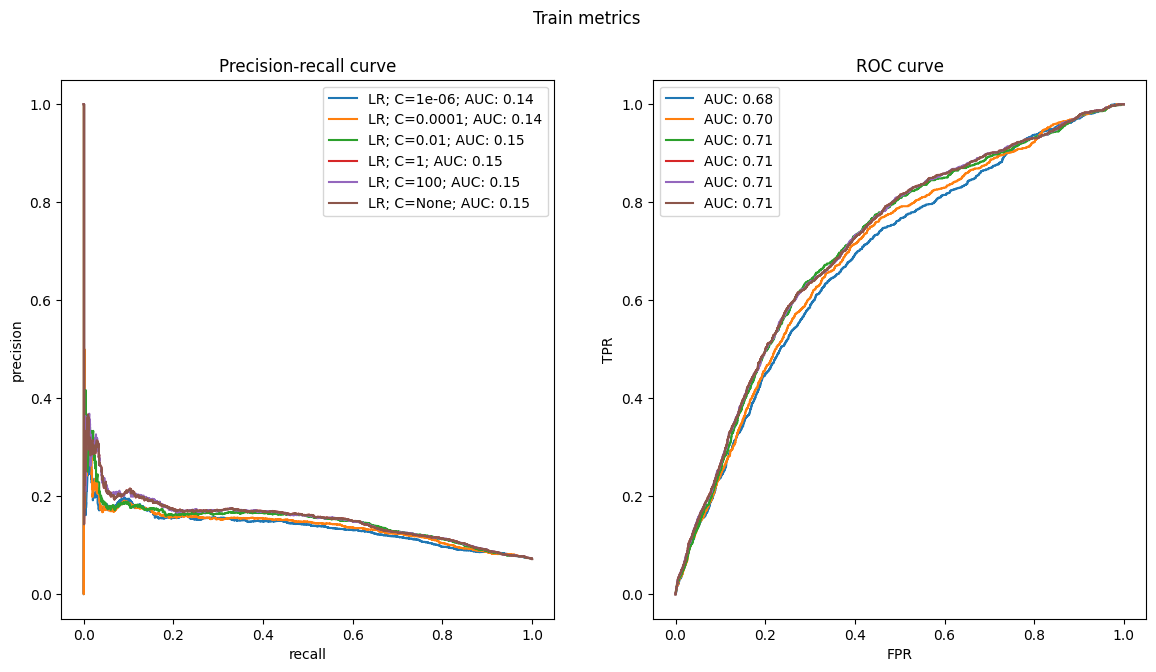

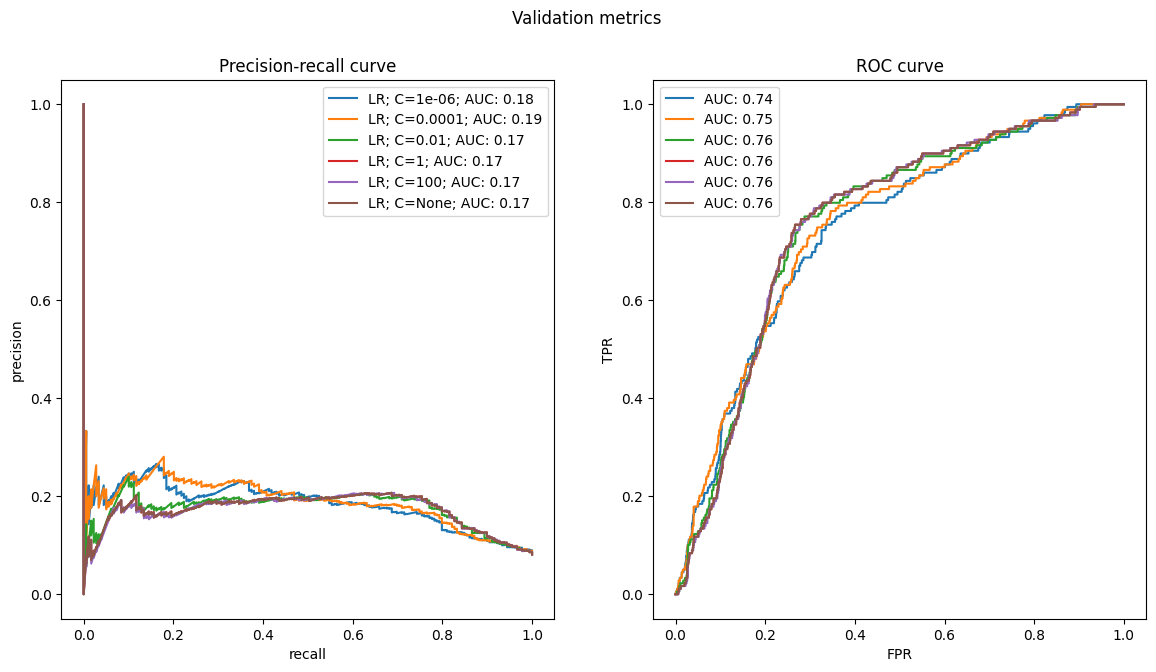

In [524]:
#usar pipelines porque une todos los pasos que forman parte del proceso de entrenamiento
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2, = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")

cs = [1e-6, 1e-4,  1e-2, 1, 100, None] #1/alpha
for c in cs:
    lr = make_pipeline(
    StandardScaler(),   #standard escaler necesita .fit para calcular media y desviacion estandar
    LogisticRegression(penalty="l2", C=c if c else 1.0),
    )
    lr.fit(X_train[train_cols], y_train)
    train_proba = lr.predict_proba(X_train[train_cols])[:,1]
    plot_metrics(
        f"LR; C={c}", y_pred=train_proba, y_test=train_df[label_col], figure=(fig1, ax1)
    )

    val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(
        f"LR; C={c}", y_pred=val_proba, y_test=val_df[label_col], figure=(fig2, ax2)
    )

    train_logloss = log_loss(y_train, train_proba)
    val_logloss = log_loss(y_val, val_proba)
    print(f"C={c}: \tTrain LogLoss: {train_logloss:.4f} \tVal LogLoss: {val_logloss:.4f}")





# Lasso 

C=0.0001: 	Train LogLoss: 0.6931 	Val LogLoss: 0.6931
C=0.001: 	Train LogLoss: 0.2789 	Val LogLoss: 0.2961
C=0.01: 	Train LogLoss: 0.2448 	Val LogLoss: 0.2559
C=1: 	Train LogLoss: 0.2402 	Val LogLoss: 0.2510
C=100: 	Train LogLoss: 0.2401 	Val LogLoss: 0.2514


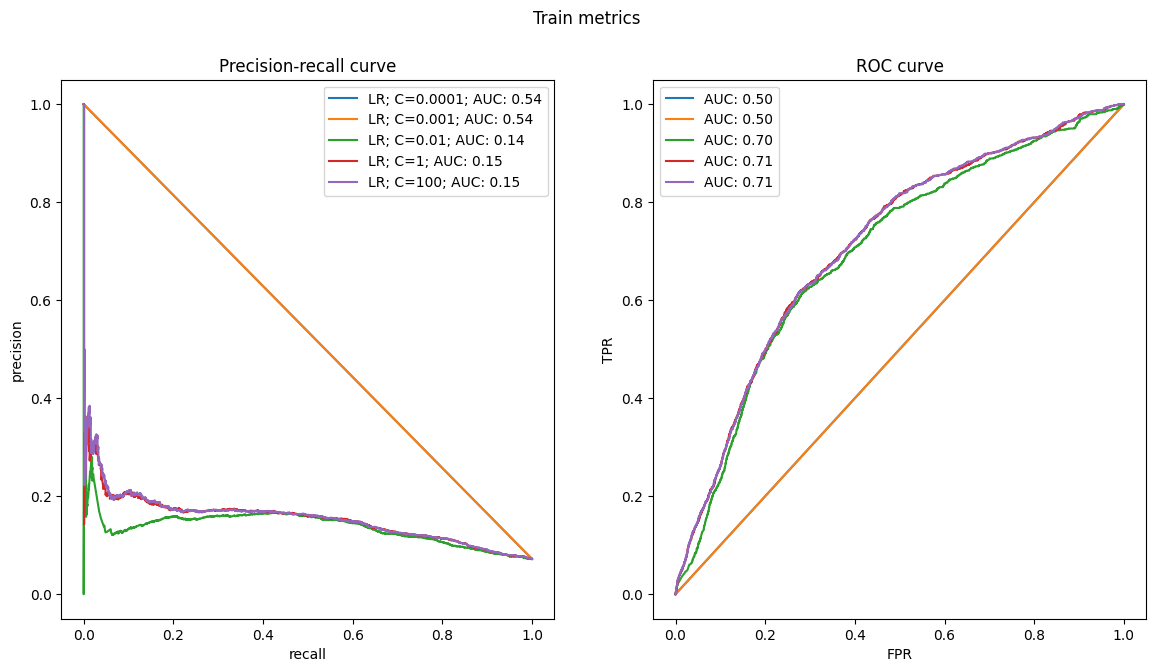

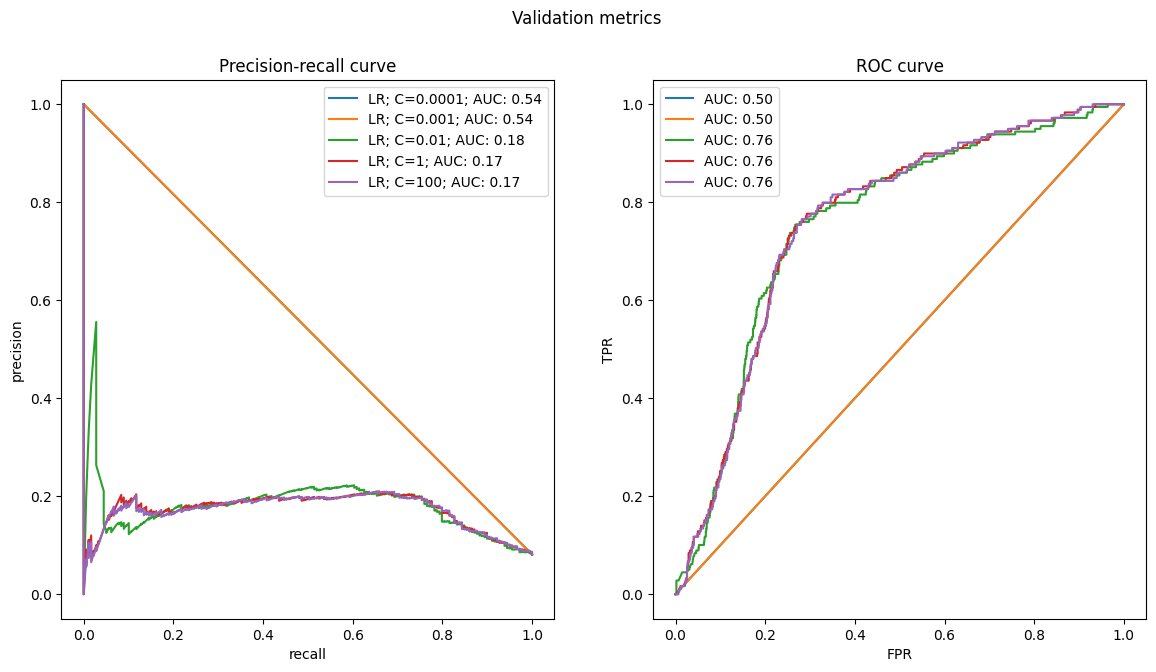

In [525]:
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2, = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")

cs = [ 1e-4, 1e-3, 1e-2, 1, 100] #1/alpha
for c in cs:
    lr = make_pipeline(
    StandardScaler(),   #standard escaler necesita .fit para calcular media y desviacion estandar
    LogisticRegression(penalty="l1", C=c if c else 1.0, solver='liblinear'),
    )
    lr.fit(X_train[train_cols], y_train)
    train_proba = lr.predict_proba(X_train[train_cols])[:,1]
    plot_metrics(
        f"LR; C={c}", y_pred=train_proba, y_test=train_df[label_col], figure=(fig1, ax1)
    )

    val_proba = lr.predict_proba(X_val[train_cols])[:, 1]
    plot_metrics(
        f"LR; C={c}", y_pred=val_proba, y_test=val_df[label_col], figure=(fig2, ax2)
    )

    train_logloss = log_loss(y_train, train_proba)
    val_logloss = log_loss(y_val, val_proba)
    print(f"C={c}: \tTrain LogLoss: {train_logloss:.4f} \tVal LogLoss: {val_logloss:.4f}")

Vamos a quedarnos con el modelo de Ridge con C=0.01 y con el de Lasso con C=1

Podemos ver los coefficients weights para saber las features a las que da importancia cada modelo y con las que se quede Lasso, utilizarlas como feature selection para entrenar modelo solo con esas features y ver si el rendimiento es similar. Esto puede ser util tambien en RandomForest ya que si tenemos muchas features que no aportan, habra muchos arboles malos y el modelo no generalizara

# Coefficient weights Ridge

<Axes: xlabel='importance', ylabel='features'>

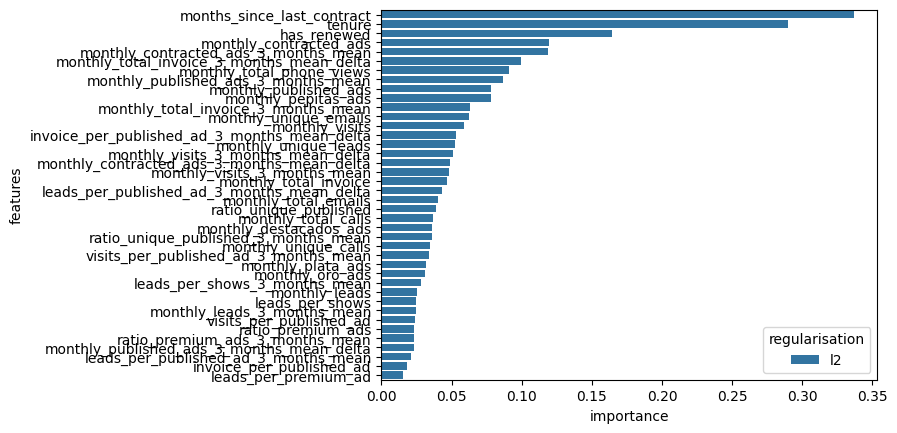

In [526]:
lr = Pipeline(
    [
        ("standard_scaler", StandardScaler()),
        ("lr", LogisticRegression(penalty="l2", C=1e-2)),  #elijo el que parecia que funcionaba mejor
    ]
)
lr.fit(X_train[train_cols], y_train)
lr_coeff_l2 = pd.DataFrame(
    {
        "features": train_cols,
        "importance": np.abs(lr.named_steps["lr"].coef_[0]),
        "regularisation": ["l2"] * len(train_cols),
    }
)
lr_coeff_l2 = lr_coeff_l2.sort_values("importance", ascending=True)



lr_coeff_l2["features"] = pd.Categorical(lr_coeff_l2["features"])
lr_coeff_l2 = lr_coeff_l2.sort_values(by=["importance"])
order_columns = lr_coeff_l2.sort_values(by="importance", ascending = False)["features"]

top_40_features_l2 = lr_coeff_l2.sort_values(by="importance", ascending=False).head(40)

sns.barplot(
    data=top_40_features_l2,
    x="importance",
    y="features",
    hue="regularisation",
    order=top_40_features_l2["features"]
)

# Coefficients weights Lasso 

<Axes: xlabel='importance', ylabel='features'>

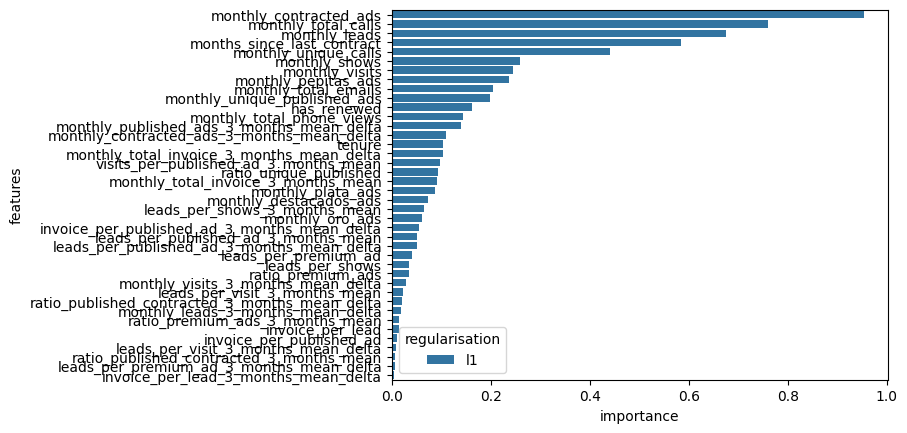

In [527]:
lr = Pipeline(
    [
        ("standard_scaler", StandardScaler()),
        ("lr", LogisticRegression(penalty="l1", C=1, solver="liblinear"),)
    ]
)
lr.fit(X_train[train_cols], y_train)
lr_coeff_l1 = pd.DataFrame(
    {
        "features": train_cols,
        "importance": np.abs(lr.named_steps["lr"].coef_[0]),
        "regularisation": "l1",
    }
)

lr_coeff_l1 = lr_coeff_l1.sort_values("importance", ascending=True)


lr_coeff_l1["features"] = pd.Categorical(lr_coeff_l1["features"])
lr_coeff_l1 = lr_coeff_l1.sort_values(by=["importance"])
order_columns = lr_coeff_l1.sort_values(by="importance", ascending = False)["features"]


top_40_features_l1 = lr_coeff_l1.sort_values(by="importance", ascending=False).head(40)


sns.barplot(
    data=top_40_features_l1,
    x="importance",
    y="features",
    hue="regularisation",
    order=top_40_features_l1["features"]
)

In [528]:
reduced_cols = top_40_features_l1['features'].tolist()

Vamos a probar a entrenar los modelos de Ridge y Lasso solo con estas columnas y ver rendimiento

Ridge C=1e-2, reduced cols: 	Train LogLoss: 0.2412 


/Users/alex/Library/Caches/pypoetry/virtualenvs/zrive-ds-BjTOAo2L-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Lasso C=1, reduced cols: 	Train LogLoss: 0.2410 
Ridge C=1e-2, reduced cols: 	Val LogLoss: 0.2519


/Users/alex/Library/Caches/pypoetry/virtualenvs/zrive-ds-BjTOAo2L-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Lasso C=1, reduced cols: 	Val LogLoss: 0.2510


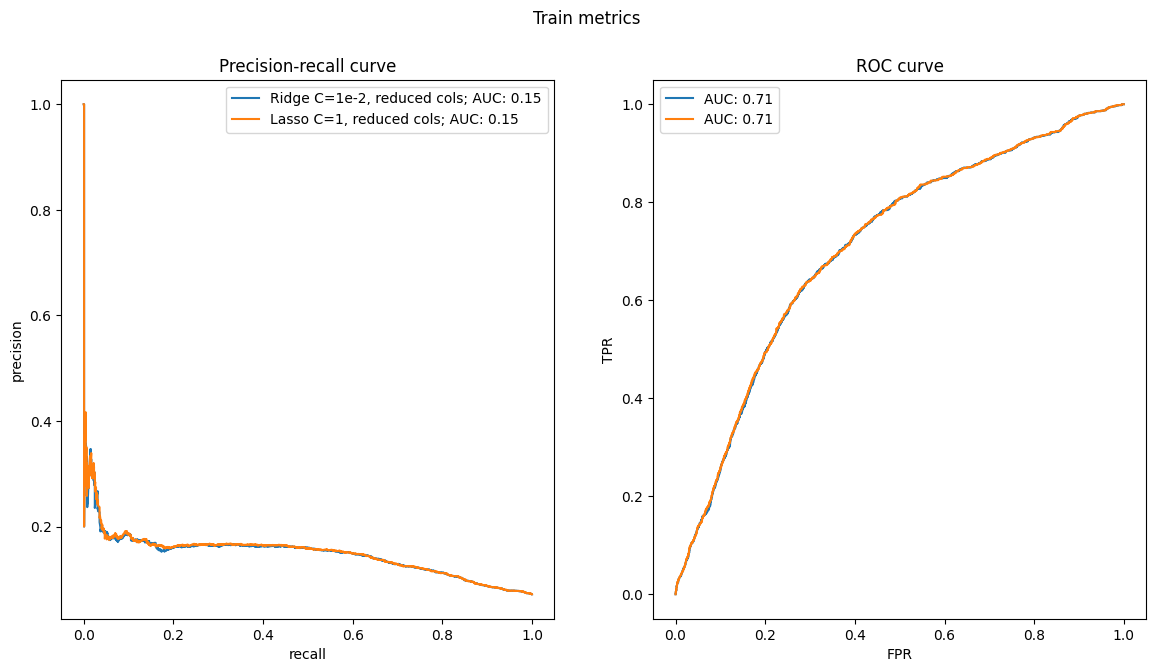

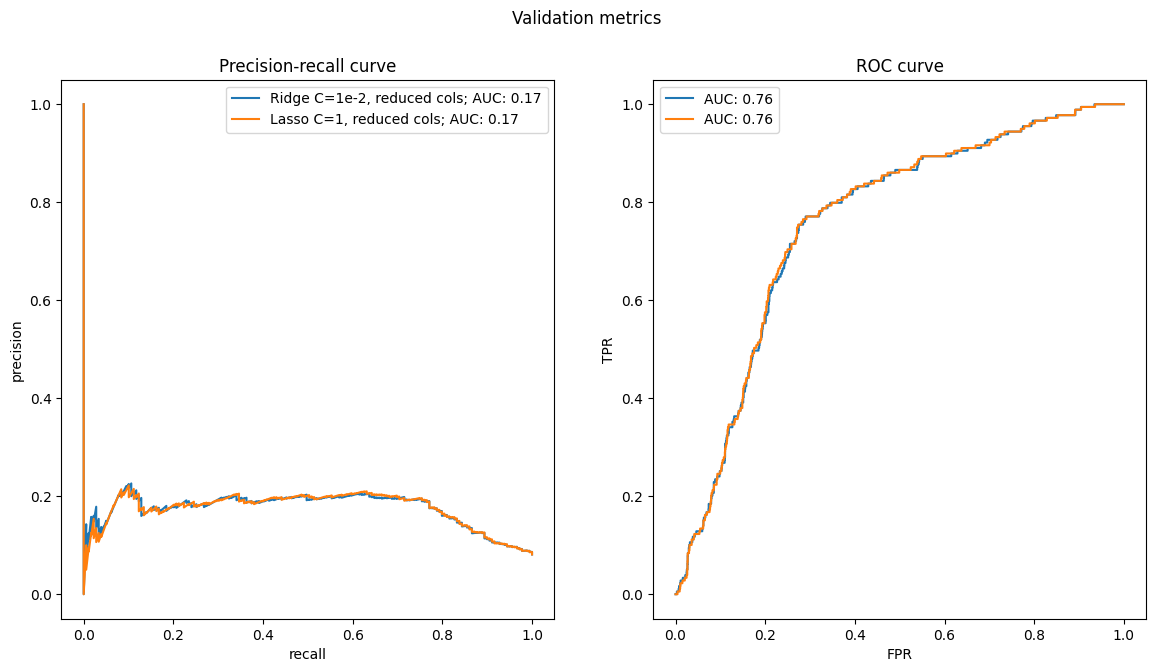

In [529]:
fig1, ax1 = plt.subplots(1,2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize= (14,7))
fig2.suptitle("Validation metrics")

lrs = [
    make_pipeline(StandardScaler(), LogisticRegression(penalty="l2", C=1e-2)),
    make_pipeline(
        StandardScaler(), LogisticRegression(penalty="l1", C=1, solver="saga")
    )
]

names = ["Ridge C=1e-2, reduced cols", "Lasso C=1, reduced cols"]
for name, lr in zip(names, lrs):
    lr.fit(X_train[reduced_cols], y_train)
    train_proba = lr.predict_proba(X_train[reduced_cols])[:, 1]
    plot_metrics(
        name, y_pred=train_proba, y_test=train_df[label_col], figure=(fig1, ax1)
    )

    train_logloss = log_loss(y_train, train_proba)
    print(f"{name}: \tTrain LogLoss: {train_logloss:.4f} ")


for name, lr in zip(names, lrs):
    lr.fit(X_train[reduced_cols], y_train)
    val_proba = lr.predict_proba(X_val[reduced_cols])[:, 1]
    plot_metrics(
        name, y_pred=val_proba, y_test=val_df[label_col], figure=(fig2, ax2)
    )

    val_logloss = log_loss(y_val, val_proba)
    print(f"{name}: \tVal LogLoss: {val_logloss:.4f}")
    

Ridge C=1e-2, reduced cols:
	Train LogLoss: 0.2412
	Val LogLoss:   0.2519



/Users/alex/Library/Caches/pypoetry/virtualenvs/zrive-ds-BjTOAo2L-py3.11/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


Lasso C=1, reduced cols:
	Train LogLoss: 0.2404
	Val LogLoss:   0.2508



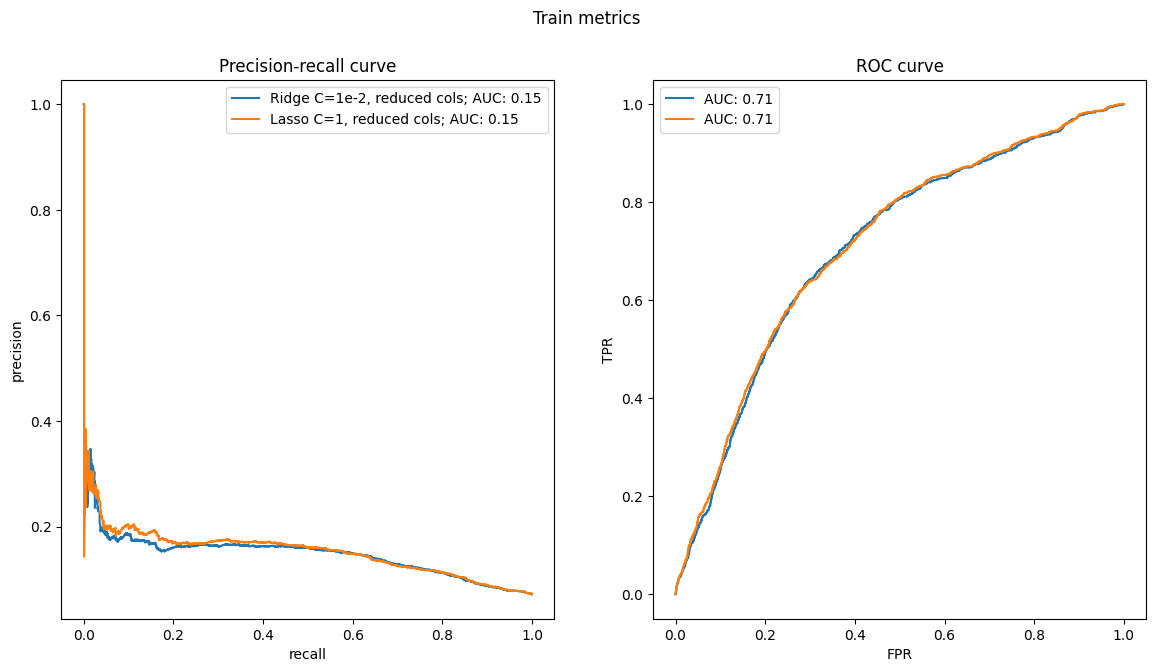

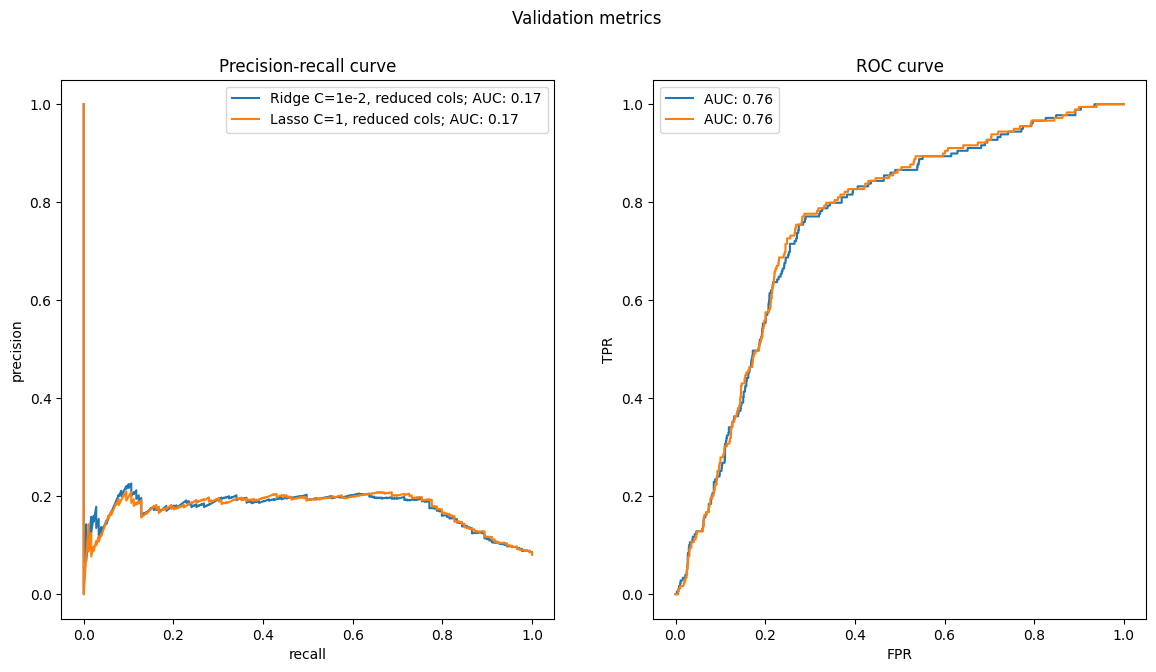

In [530]:

fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics")

fig2, ax2 = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics")

# Configurar modelos con parámetros para evitar warnings
lrs = [
    make_pipeline(
        StandardScaler(), 
        LogisticRegression(penalty="l2", C=1e-2, solver='lbfgs', max_iter=1000, random_state=42)
    ),
    make_pipeline(
        StandardScaler(),
        LogisticRegression(penalty="l1", C=1, solver="saga", max_iter=1000, random_state=42)
    )
]

names = ["Ridge C=1e-2, reduced cols", "Lasso C=1, reduced cols"]

for name, model in zip(names, lrs):
    # Entrenamiento del modelo una sola vez
    model.fit(X_train[reduced_cols], y_train)
    
    # Métricas de entrenamiento
    train_proba = model.predict_proba(X_train[reduced_cols])[:, 1]
    plot_metrics(
        name, y_pred=train_proba, y_test=y_train, figure=(fig1, ax1)
    )
    train_logloss = log_loss(y_train, train_proba)
    
    # Métricas de validación
    val_proba = model.predict_proba(X_val[reduced_cols])[:, 1]
    plot_metrics(
        name, y_pred=val_proba, y_test=y_val, figure=(fig2, ax2)
    )
    val_logloss = log_loss(y_val, val_proba)
    
    # Mostrar ambos resultados juntos
    print(f"{name}:")
    print(f"\tTrain LogLoss: {train_logloss:.4f}")
    print(f"\tVal LogLoss:   {val_logloss:.4f}\n")

# Random Forest con todas las columnas

In [531]:
from sklearn.ensemble import RandomForestClassifier

max_depth=3, n_estimators=200: 	Train LogLoss: 0.6178 	Val LogLoss: 0.6230
max_depth=3, n_estimators=400: 	Train LogLoss: 0.6179 	Val LogLoss: 0.6228
max_depth=5, n_estimators=200: 	Train LogLoss: 0.5695 	Val LogLoss: 0.5805
max_depth=5, n_estimators=400: 	Train LogLoss: 0.5687 	Val LogLoss: 0.5799
max_depth=8, n_estimators=200: 	Train LogLoss: 0.4511 	Val LogLoss: 0.4817
max_depth=8, n_estimators=400: 	Train LogLoss: 0.4517 	Val LogLoss: 0.4819
max_depth=None, n_estimators=200: 	Train LogLoss: 0.0550 	Val LogLoss: 0.2806
max_depth=None, n_estimators=400: 	Train LogLoss: 0.0549 	Val LogLoss: 0.2668


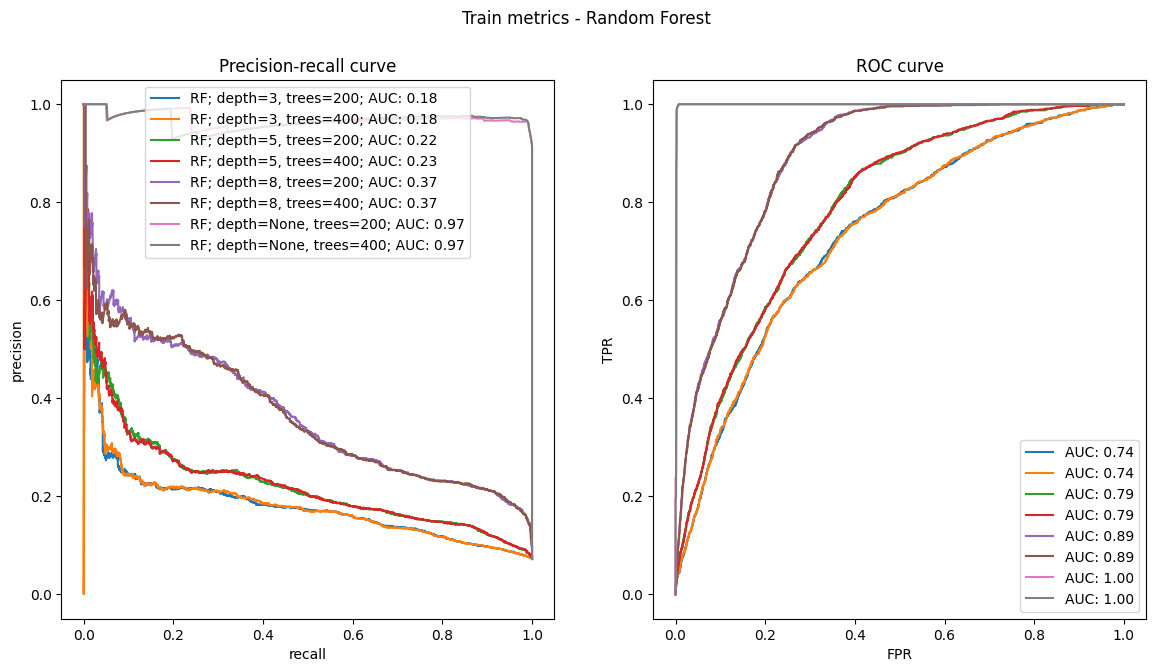

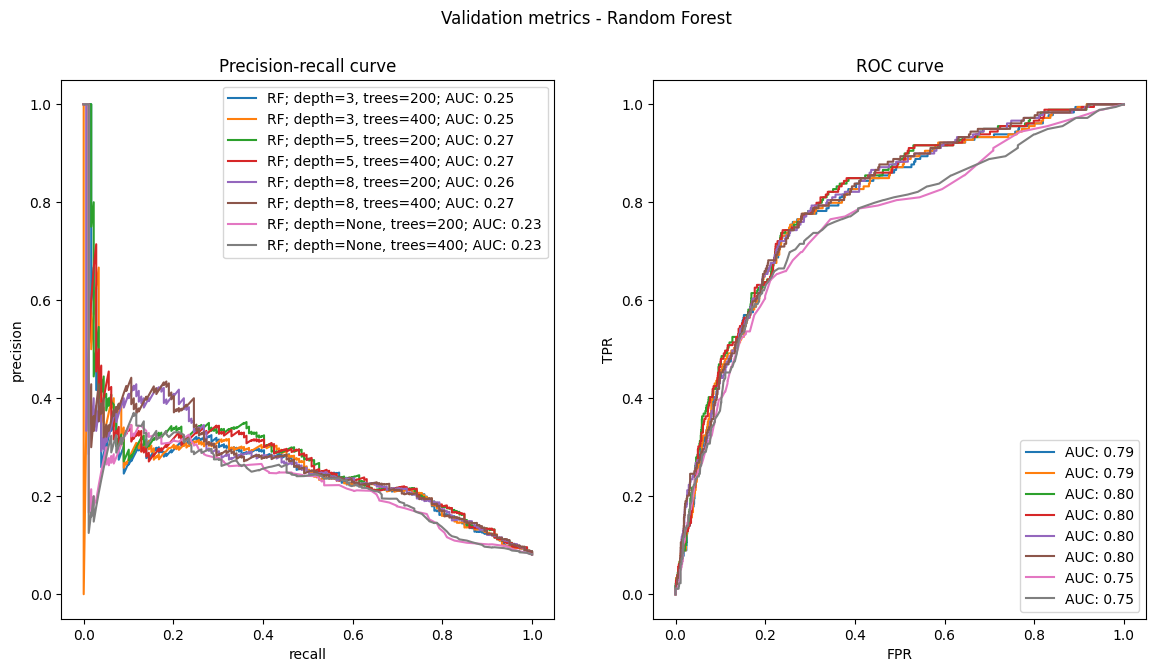

In [532]:
# Configurar parámetros a probar
max_depths = [3, 5, 8, None]
n_estimators_list = [ 200, 400]

# Configurar plots
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics - Random Forest")

fig2, ax2 = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics - Random Forest")

for max_depth in max_depths:
    for n_estimators in n_estimators_list:
        rf = make_pipeline(
            RandomForestClassifier(
                max_depth=max_depth,
                n_estimators=n_estimators,
                random_state=46,
                class_weight='balanced'  # Para manejar desbalance de clases
            )
        )
        
        rf.fit(X_train[train_cols], y_train)

        # Métricas train
        train_proba = rf.predict_proba(X_train[train_cols])[:,1]
        plot_metrics(
            f"RF; depth={max_depth}, trees={n_estimators}", 
            train_proba, 
            y_train,
            figure=(fig1, ax1)
        )

        # Métricas validation
        val_proba = rf.predict_proba(X_val[train_cols])[:,1]
        plot_metrics(
            f"RF; depth={max_depth}, trees={n_estimators}", 
            val_proba,
            y_val,
            figure=(fig2, ax2)
        )

        train_logloss = log_loss(y_train, train_proba)
        val_logloss = log_loss(y_val, val_proba)
        print(f"max_depth={max_depth}, n_estimators={n_estimators}: \tTrain LogLoss: {train_logloss:.4f} \tVal LogLoss: {val_logloss:.4f}")


In [533]:
from sklearn.metrics import precision_recall_curve

# Después de entrenar el modelo y obtener val_proba:
precision, recall, thresholds = precision_recall_curve(y_val, val_proba)

# Encontrar el índice donde el recall está más cerca de 0.3
target_recall = 0.7
closest_idx = np.argmin(np.abs(recall - target_recall))

# Obtener la precisión correspondiente
precision_at_target_recall = precision[closest_idx]

print(f"Precisión en recall={target_recall:.1f}: {precision_at_target_recall:.2f}")

Precisión en recall=0.7: 0.19


# Random Forest con reduced cols de Lasso

C=100: 	Train LogLoss: 0.1073 	Val LogLoss: 0.2883


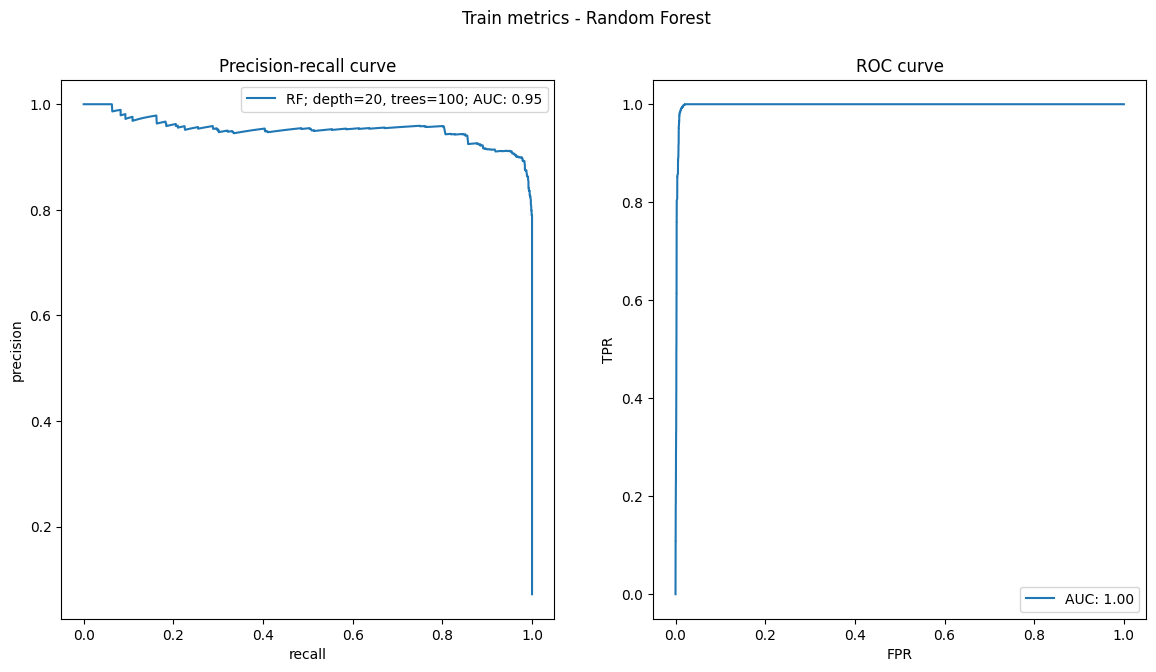

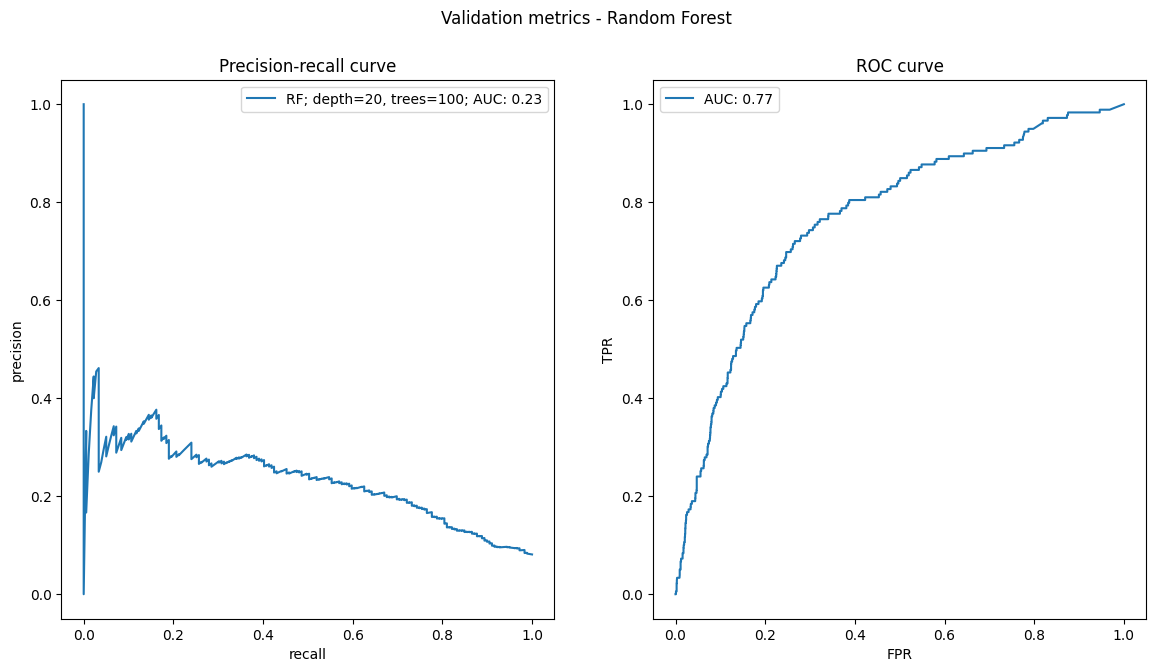

In [534]:
from sklearn.ensemble import RandomForestClassifier

# Configurar parámetros a probar
max_depths = [20]
n_estimators_list = [100]

# Configurar plots
fig1, ax1 = plt.subplots(1, 2, figsize=(14,7))
fig1.suptitle("Train metrics - Random Forest")

fig2, ax2 = plt.subplots(1, 2, figsize=(14,7))
fig2.suptitle("Validation metrics - Random Forest")

for max_depth in max_depths:
    for n_estimators in n_estimators_list:
        rf = make_pipeline(
            RandomForestClassifier(
                max_depth=max_depth,
                n_estimators=n_estimators,
                random_state=46,
                class_weight='balanced'  # Para manejar desbalance de clases
            )
        )
        
        rf.fit(X_train[reduced_cols], y_train)

        # Métricas train
        train_proba = rf.predict_proba(X_train[reduced_cols])[:,1]
        plot_metrics(
            f"RF; depth={max_depth}, trees={n_estimators}", 
            train_proba, 
            y_train,
            figure=(fig1, ax1)
        )

        # Métricas validation
        val_proba = rf.predict_proba(X_val[reduced_cols])[:,1]
        plot_metrics(
            f"RF; depth={max_depth}, trees={n_estimators}", 
            val_proba,
            y_val,
            figure=(fig2, ax2)
        )

        train_logloss = log_loss(y_train, train_proba)
        val_logloss = log_loss(y_val, val_proba)
        print(f"C={c}: \tTrain LogLoss: {train_logloss:.4f} \tVal LogLoss: {val_logloss:.4f}")